<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet P8 : <br>
    Déployez un modèle dans le cloud </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    Notebook - emr_CLOUD
</p>

#  **Ouverture Pyspark et Librairies**

In [1]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1704915397301_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<u>Affichage des informations sur la session en cours et liens vers Spark UI</u> :

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1704915397301_0003,pyspark,idle,Link,Link,None,✔


### 1- Installation des packages

In [3]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Importation de certaines fonctions spécifiques de PySpark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2- Création des PATHs

In [4]:
# Définition des chemins (paths)
PATH = 's3://p8mauyves/data' # Chemin racine
#PATH = '/Users/admin/P_8/'
PATH_Data = PATH+'Test'        # Chemin vers le répertoire de données
PATH_Result = PATH+'Results'   # Chemin vers le répertoire de résultats

# Affichage des chemins pour vérification
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://p8mauyves/data
PATH_Data:   s3://p8mauyves/dataTest
PATH_Result: s3://p8mauyves/dataResults

### 3- Traitement des données

In [5]:
# Lire des fichiers binaires du format "binaryFile" en utilisant Spark
# Filtrer les fichiers avec l'extension "*.jpg" et rechercher récursivement dans les sous-répertoires
# Charger les fichiers à partir du chemin 's3://p8mauyves' dans un DataFrame nommé images

images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load('s3://p8mauyves/')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://p8mauyves/Ap...|2024-01-03 20:12:22|  4629|[FF D8 FF E0 00 1...|
|s3://p8mauyves/Ap...|2024-01-03 20:11:42|  4628|[FF D8 FF E0 00 1...|
|s3://p8mauyves/Ap...|2024-01-03 20:11:16|  4627|[FF D8 FF E0 00 1...|
|s3://p8mauyves/Ap...|2024-01-03 20:11:37|  4627|[FF D8 FF E0 00 1...|
|s3://p8mauyves/Ap...|2024-01-03 20:11:37|  4626|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [7]:
# Importer les fonctions element_at, split du module pyspark.sql.functions
from pyspark.sql.functions import element_at
from pyspark.sql.functions import element_at, split

# Ajouter une colonne 'label' à partir de l'avant-dernier élément de la séparation du chemin
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))

# Afficher le schéma du DataFrame images
print(images.printSchema())

# Afficher les cinq premières lignes des colonnes 'path' et 'label'
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------+---------------+
|path                                        |label          |
+--------------------------------------------+---------------+
|s3://p8mauyves/Apple Pink Lady/r_65_100.jpg |Apple Pink Lady|
|s3://p8mauyves/Apple Pink Lady/r_92_100.jpg |Apple Pink Lady|
|s3://p8mauyves/Apple Pink Lady/r_211_100.jpg|Apple Pink Lady|
|s3://p8mauyves/Apple Pink Lady/r_63_100.jpg |Apple Pink Lady|
|s3://p8mauyves/Apple Pink Lady/r_73_100.jpg |Apple Pink Lady|
+--------------------------------------------+---------------+
only showing top 5 rows

None

#### a- Préparation du modèle

In [8]:
# Importer la classe MobileNetV2 du module des applications de Keras
from tensorflow.keras.applications import MobileNetV2

# Créer un modèle MobileNetV2 avec des poids pré-entraînés sur ImageNet
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# Créer un nouveau modèle en utilisant l'entrée du modèle précédent
# et en prenant comme sortie la couche avant la dernière du modèle
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# Diffuser les poids du nouveau modèle à travers Spark
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Afficher un résumé du nouveau modèle
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [12]:
def model_fn():
    """
    Renvoie un modèle MobileNetV2 avec la couche supérieure supprimée
et les poids pré-entraînés diffusés.
    """
    # Charger le modèle MobileNetV2 avec les poids pré-entraînés
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    
    # Désactiver l'apprentissage pour toutes les couches du modèle
    for layer in model.layers:
        layer.trainable = False
        
    # Créer un nouveau modèle sans la couche supérieure
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    
    # Appliquer les poids pré-entraînés diffusés
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### b- Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [13]:
def preprocess(content):
    """
    Prétraite les octets d'image bruts pour la prédiction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    
    # Pour certaines couches, les caractéristiques de sortie seront des tenseurs multidimensionnels.
    # Nous aplatissions les tenseurs de caractéristiques en vecteurs pour un stockage plus facile dans les DataFrames Spark.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    Cette méthode est une UDF (User-Defined Function) pandas Scalar Iterator enveloppant notre fonction de caractérisation. Le décorateur spécifie que cela renvoie une colonne Spark DataFrame de type ArrayType(FloatType).

:param content_series_iter: Cet argument est un itérateur sur des lots de données, où chaque lot
est une série pandas de données d'image.
    '''
    #Avec les UDF pandas Scalar Iterator, nous pouvons charger le modèle une fois puis le réutiliser.
    # pour plusieurs lots de données.Cela amortit les frais généraux liés au chargement de gros modèles.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1704915397301_0003/container_1704915397301_0003_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:403: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

### 4- Extraction des features

In [14]:
# Configuration de l'option "spark.sql.execution.arrow.maxRecordsPerBatch" à la valeur "1024"
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Créer un DataFrame de fonctionnalités en répartissant les données sur 24 partitions
# Sélectionner les colonnes 'path' et 'label' du DataFrame images
# Appliquer la fonction d'extraction des fonctionnalités (featurize_udf) sur la colonne 'content' et renommer la sortie en 'features'
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
from pyspark.ml.functions import vector_to_array
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 5- Application du PCA

In [17]:
# Transformation des features en vecteur dense

from pyspark.ml.functions import array_to_vector

sparkDF = features_df.withColumn("features_vectorized", array_to_vector("features"))
sparkDF.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+--------------------+--------------------+
|                path|            label|            features| features_vectorized|
+--------------------+-----------------+--------------------+--------------------+
|s3://p8mauyves/Ap...|  Apple Pink Lady|[0.1960293, 0.113...|[0.19602930545806...|
|s3://p8mauyves/Ap...|  Apple Pink Lady|[0.17898463, 0.04...|[0.17898462712764...|
|s3://p8mauyves/Ap...|  Apple Pink Lady|[0.98299426, 0.01...|[0.98299425840377...|
|s3://p8mauyves/Ch...|Cherry Wax Yellow|[0.61805654, 0.10...|[0.61805653572082...|
|s3://p8mauyves/Ch...|Cherry Wax Yellow|[0.27540585, 0.02...|[0.27540585398674...|
+--------------------+-----------------+--------------------+--------------------+
only showing top 5 rows

In [18]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol = 'features_vectorized', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(sparkDF)

# Lorsque nous transformons le Dataframe, l'ancienne
# caractéristique restera toujours présente en elle
df_scaled = scaler.transform(sparkDF)

# Afficher les six premières lignes du DataFrame standardisé
df_scaled.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+--------------------+--------------------+--------------------+
|                path|            label|            features| features_vectorized|      scaledFeatures|
+--------------------+-----------------+--------------------+--------------------+--------------------+
|s3://p8mauyves/Ap...|  Apple Pink Lady|[0.1960293, 0.113...|[0.19602930545806...|[-0.2075054344109...|
|s3://p8mauyves/Ap...|  Apple Pink Lady|[0.17898463, 0.04...|[0.17898462712764...|[-0.2840561488596...|
|s3://p8mauyves/Ap...|  Apple Pink Lady|[0.98299426, 0.01...|[0.98299425840377...|[3.32689563941691...|
|s3://p8mauyves/Ap...|  Apple Pink Lady|[0.31005275, 0.08...|[0.31005275249481...|[0.30459436385795...|
|s3://p8mauyves/Ch...|Cherry Wax Yellow|[0.1632067, 0.490...|[0.16320669651031...|[-0.3549176716097...|
|s3://p8mauyves/Ch...|Cherry Wax Yellow|[0.61805654, 0.10...|[0.61805653572082...|[1.68789472317164...|
+--------------------+-----------------+--------------------+---

In [19]:
# Compter le nombre de features
nb_composante = len(df_scaled.select('scaledFeatures').take(1)[0][0])
nb_composante

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1280

In [20]:
# Fonction pour réduction de dimensions PCA
def reduc_dim_pca(features):
    '''Réduction des dimensions PCA sur les feature
    Entrée:
    - features de l\'image

    Retour:
    - pca
    - pca_matrix: résultat de la réduction de dimensions
    '''
    # Conversion d'un tableau (array) en vecteur dense
    # Création d'un fonction utilisateur avec udf
    #vector_dense = udf(lambda x: Vectors.dense(x), VectorUDT())
    img_vd_df = features.select("path","label","scaledFeatures")

    # PCA
    pca_spark = PCA(inputCol="scaledFeatures", outputCol="features_pca", k=100)
    pca = pca_spark.fit(img_vd_df)
    pca_matrix = pca.transform(img_vd_df)

    return pca, pca_matrix

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
from pyspark.ml.feature import PCA
from pyspark.ml.functions import array_to_vector

# Calculer le nombre de composantes en extrayant la longueur de la première observation dans la colonne 'scaledFeatures'
pca, pca_matrix = reduc_dim_pca(df_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# Appliquer l'analyse en composantes principales (PCA) sur les données standardisées

pca = PCA(
    # Paramètres :
    k = nb_composante, #  Nombre de composantes principales à conserver
    inputCol = 'scaledFeatures', #  Colonne d'entrée contenant les caractéristiques mises à l'échelle
    outputCol = 'pcaFeatures' # Colonne de sortie pour les caractéristiques PCA
).fit(df_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

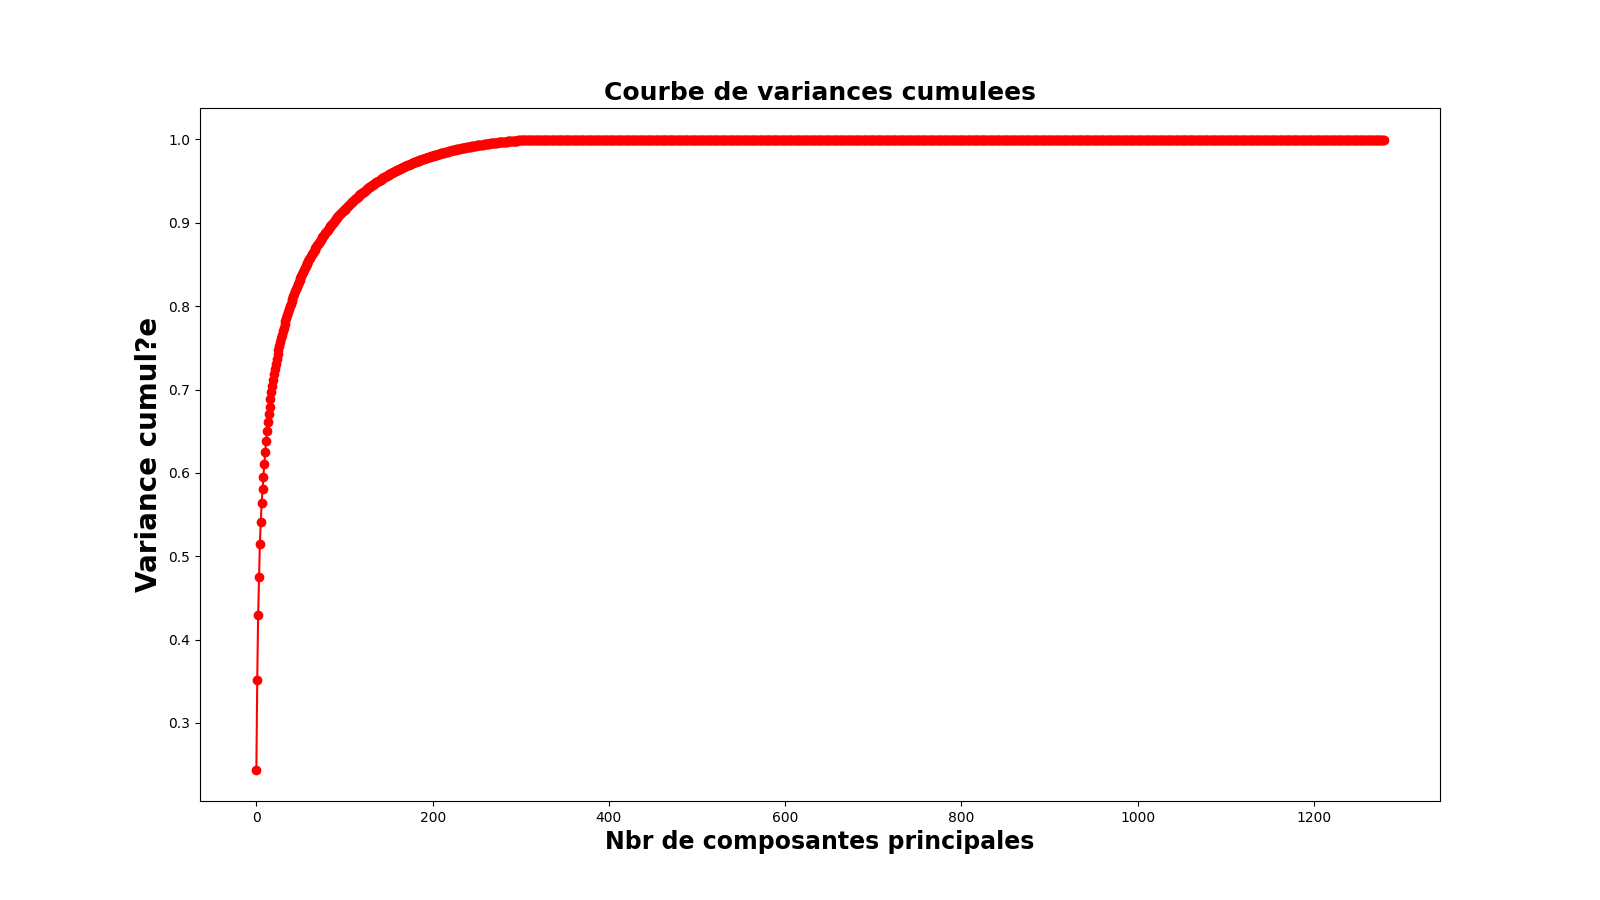

In [23]:
import matplotlib.pyplot as plt

# Créer un tracé de la variance cumulée expliquée par les composantes principales
# Paramètres :
#   - figsize : Taille de la figure
#   - ylabel : Libellé de l'axe des ordonnées (variance cumulée)
#   - xlabel : Libellé de l'axe des abscisses (nombre de composantes principales)
#   - plot : Tracer la courbe de la variance cumulée en fonction du nombre de composantes
#   - title : Titre du tracé

plt.figure(figsize=(16, 9))
plt.ylabel("Variance cumulée", weight='bold', size=20)
plt.xlabel('Nbr de composantes principales', weight='bold', size=17)
plt.plot(pca.explainedVariance.cumsum(),c="red",marker='o')
plt.title('Courbe de variances cumulees', size=18, weight='bold')
%matplot plt

In [24]:
# Calculer la somme cumulative des variances expliquées par chaque composante principale
pca.explainedVariance.cumsum()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([0.24403884, 0.3514041 , 0.42894464, ..., 1.        , 1.        ,
       1.        ])

In [25]:
# Calculer le nombre de composantes nécessaires pour expliquer 95% de la variance cumulative
cumsum = 0
for i in pca.explainedVariance.cumsum():
    cumsum += 1
    if(i > 0.8):
        print(
            '{} composantes expliquent 80% de la variance'.format(cumsum))
        break

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

40 composantes expliquent 80% de la variance

In [26]:
# Appliquer l'analyse en composantes principales (PCA) pour réduire la dimensionnalité des données
# Paramètres :
#   - k : Nombre de composantes principales à conserver ou proportion cumulée à conserver (cumsum)
#   - inputCol : Colonne d'entrée contenant les caractéristiques mises à l'échelle
#   - outputCol : Colonne de sortie pour les caractéristiques réduites mises à l'échelle

pca = PCA(
    k=cumsum,
    inputCol='scaledFeatures',
    outputCol='features_pca')

# Appliquer le modèle PCA aux données mises à l'échelle
model_pca = pca.fit(df_scaled)
df_final = model_pca.transform(df_scaled)

# Supprimer la colonne "scaledFeatures" des données finales
df_final = df_final.drop('path', 'scaledFeatures', 'features', 'features_vectorized')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Afficher les six premières lignes du DataFrame final. 
# après l'application de l'analyse en composantes principales (PCA)
df_final.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+--------------------+
|            label|        features_pca|
+-----------------+--------------------+
|  Apple Pink Lady|[-16.351299842695...|
|  Apple Pink Lady|[-14.918491385552...|
|  Apple Pink Lady|[-21.200385440370...|
|  Apple Pink Lady|[-20.650010160309...|
|Cherry Wax Yellow|[14.6127071972654...|
|Cherry Wax Yellow|[17.7168663958329...|
+-----------------+--------------------+
only showing top 6 rows

### 6- Enregistrement sous format Parquet

In [28]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://p8mauyves/dataResults

In [29]:
# Écrire les données finales du DataFrame dans un format Parquet en écrasant tout contenu existant
# Paramètres :
#   - mode : Mode d'écriture, dans ce cas, "overwrite" pour écraser le contenu existant
#   - parquet : Format de stockage efficace pour les données tabulaires

df_final.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
# Importer la bibliothèque pyarrow et utiliser la méthode parquet pour lire une table depuis le chemin spécifié (PATH_Result)
import pyarrow.parquet as pq
# Convertir la table parquet en un DataFrame pandas
df = pq.read_table(source=PATH_Result).to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# Arrêter la session Spark en cours
spark.stop()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…